In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

class Wave:
    source = {"x": 0, "y": 0}
    distance_map = None

    def __init__(self, x, y):
        self.source = {"x": x, "y": y}
    
    def create_distance_map(self, x, y):
        self.distance_map = np.sqrt((x - self.source["x"])**2 + (y - self.source["y"])**2)

def init_waves(type_of_simulation):
    if type_of_simulation == "single_wave":
        return [Wave(0, 0)]    
    
    if type_of_simulation == "single_slit_diffraction":
        return [Wave(0, (offset * np.pi))
                for offset in (-1.5, -0.5, 0.5, 1.5)]
                
    if type_of_simulation == "double_slit_diffraction":
        return [Wave(0, offset * np.pi + direction * slit_distance / 2)
                for offset in (-1.5, -0.5, 0.5, 1.5)
                for direction in (-1, 1)]
    
    if type_of_simulation == "double_slit_no_diffraction":
        return [Wave(0, direction * slit_distance / 2)
                for direction in (-1, 1)]    
    
def create_wave_pattern(waves, step, steps):
    return abs(sum([np.sin(wave.distance_map - 2 * np.pi * step / steps) for wave in waves]))

def update_plot_3d(step, x, y, z_over_time, plot, ax):
    #print(f"Step {step + 1} from {steps}")
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, z_over_time[:,:,step], rstride=quality, cstride=quality, cmap=plt.cm.winter, linewidth=0, antialiased=True)

def create_animated_3d_plot(x, y, z_over_time, type_of_simulation):
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(azim = 0, elev = 90)
    ax.set_zticks([])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.autoscale(tight=True)

    plot = [ax.plot_surface(x, y, z_over_time[:,:,0], rstride=quality, cstride=quality, cmap=plt.cm.winter, linewidth=0, antialiased=True)]

    ani = FuncAnimation(fig, update_plot_3d, frames = steps, fargs = (x, y, z_over_time, plot, ax), blit = False)

    ani.save(f"{type_of_simulation}_-_animated_3d.gif", writer = PillowWriter(fps = steps // 2))

def update_plot_wall(step, wall_over_time, sum_over_time, plots, y):
    print(f"Step {step + 1} from {steps}")
    plots[0].set_data(y, wall_over_time[:, step])
    plots[1].set_data(y, sum_over_time[:, step])
    
    return [plots]

def create_animated_wall_plot(breadth, z_over_time, type_of_simulation):
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111)
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])

    y = np.arange(-breadth, breadth, 0.05)
    
    wall_over_time = z_over_time[:, -1, :]
    plt.ylim((-0.2, np.amax(wall_over_time) + 0.2))
    plt.ylabel("Intensity over Time")
    
    sum_over_time = np.zeros((len(y), steps))
    sum_over_time[:, 0] = wall_over_time[:, 0] / steps
    
    for step in range(1, steps):
        sum_over_time[:, step] = sum_over_time[:, step - 1] + wall_over_time[:, step] / steps
    
    plots = [ax.plot(y, wall_over_time[:, 0])[0], ax.plot(y, sum_over_time[:, 0])[0]]

    ani = FuncAnimation(fig, update_plot_wall,
                        frames = steps,
                        fargs = (wall_over_time, sum_over_time, plots, y),
                        blit = False)

    ani.save(f"{type_of_simulation}_-_animated_wall.gif", writer = PillowWriter(fps = steps // 3))
    
    plt.clf()
    ax = fig.add_subplot(111)
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    plt.ylim((-0.2, np.amax(wall_over_time) + 0.2))
    plt.ylabel("Intensity over Time")
    plt.plot(sum_over_time[:, -1], color="orange")
    plt.savefig(f"{type_of_simulation}_-_wall_result.png")

# Configuration of environment

slit_distance = 8 * np.pi       # Distance of the center of the two slits. Only relevant for double-slit scenarios.
wall_distance = 40              # Distance from slits to wall.
breadth = 100                   # Breadth of wall.
steps = 10                      # Steps for the simulation to take. Fast prototypes are OK at 10, good quality starts around 50.
quality = 1                     # Controlling the stride of the 3d plots. Fast prototypes are OK at 20, great quality is 1.

# You can remove types of simulations that you are not interested in from the list

for type_of_simulation in ["double_slit_diffraction"]:

    waves = init_waves(type_of_simulation)

    x, y = np.arange(0, wall_distance, 0.05), np.arange(-breadth, breadth, 0.05)
    x, y = np.meshgrid(x, y)

    for wave in waves:
        wave.create_distance_map(x, y)

    z_over_time = np.zeros((len(x), len(y[0]), steps))
    for step in range(steps):
        z_over_time[:,:,step] = create_wave_pattern(waves, step, steps)

    # create_animated_3d_plot(x, y, z_over_time, type_of_simulation)
    # create_animated_wall_plot(breadth, z_over_time, type_of_simulation)

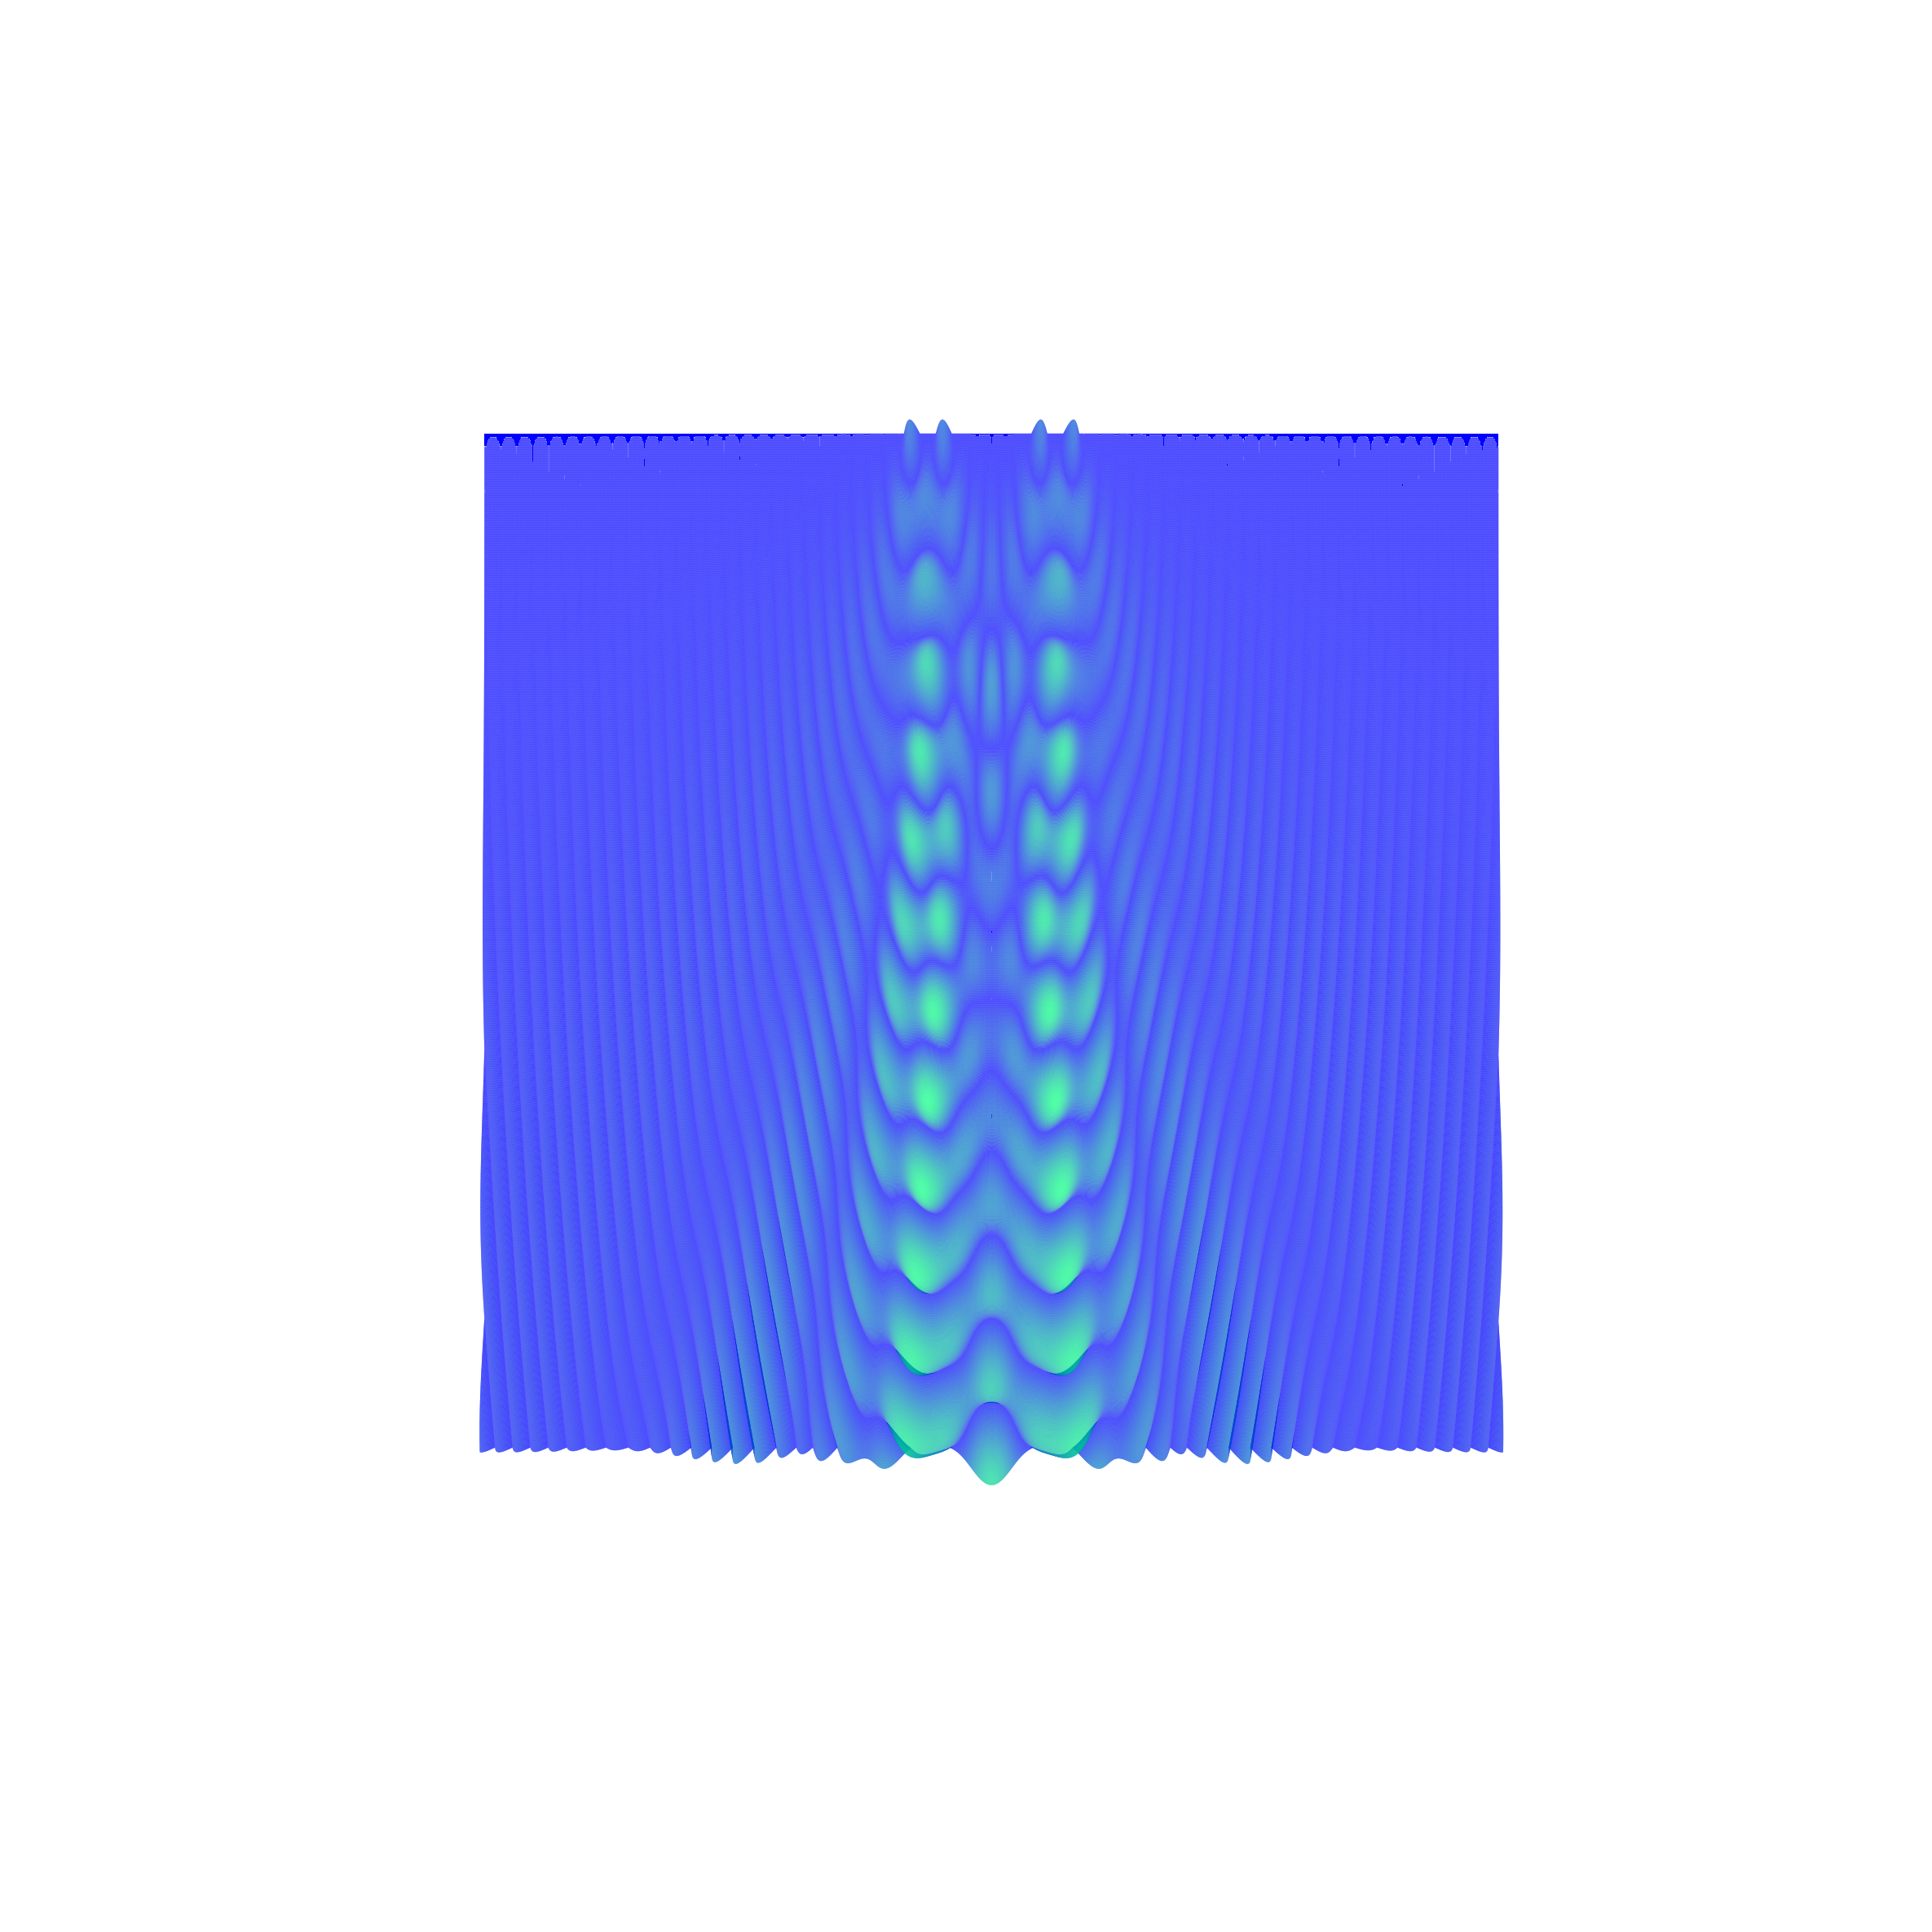

In [5]:
step = 9
fig = plt.figure(figsize = (20, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim = 0, elev = 90)
ax.axis('off')

#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.autoscale(tight=True)
ax.plot_surface(x, y, z_over_time[:,:,step], rstride=quality, cstride=quality, cmap=plt.cm.winter, linewidth=0, antialiased=True)